# 6. Learning, a better way

Let's try again, but this time only with 2 classes to learn.

## 6.1. Preparing the notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm as cmap

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

sns.set(font='sans')

## 6.2. Learning, again, with random forest

We aren't going to change the configuration of the cross-validation method and the random forests. But, let's save a little more data, like the `P/R` and the `ROC` scores.

In [3]:
labelize_columns = ['medallion', 'hack_license', 'vendor_id']

interize_columns = ['pickup_month', 'pickup_weekday', 'pickup_non_working_today', 'pickup_non_working_tomorrow']

feature_columns = ['medallion', 'hack_license', 'vendor_id', 'pickup_month', 'pickup_weekday', 'pickup_day', 'pickup_time_in_mins',
                   'pickup_non_working_today', 'pickup_non_working_tomorrow', 'fare_amount', 'surcharge', 'tolls_amount',
                   'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude',
                   'dropoff_longitude', 'dropoff_latitude']

class_column = 'tip_label'

In [32]:
data = pd.read_csv('dataset_small.csv')

In [ ]:
# tip_labels = ['< 20', '>= 20']
# data['tip_label'] = ''
# tip_ranges_by_label = [[0.0, 20.0], [20.0, 51.0]]

# for i, tip_label in enumerate(tip_labels):
#     tip_mask = ((data.tip_perc >= tip_ranges_by_label[i][0]) & (data.tip_perc < tip_ranges_by_label[i][1]))
#     data.tip_label[tip_mask] = tip_label
    
#     tip_mask = None

In [20]:
for column in labelize_columns:
    real_column = data[column].values
    
    le = LabelEncoder()
    le.fit(real_column)
    labelized_column = le.transform(real_column)
    
    data[column] = labelized_column
    
    le = None
    real_column = None
    labelized_column = None

In [21]:
for column in interize_columns:
    data[column] = data[column].astype(int)

In [22]:
data_features = data[feature_columns].values
data_classes = data[class_column].values

data = None

In [23]:
cross_validation = StratifiedShuffleSplit(data_classes, n_iter=10, test_size=0.1, random_state=0)

scores = []
confusion_matrices = []
precision_scores = {}
recall_scores = {}
pr_auc_scores = {}
fpr_scores = {}
tpr_scores = {}
roc_auc_scores = {}

for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    
    clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
    
    if not pr_auc_scores:
        for c in clf.classes_:
            precision_scores[c] = []
            recall_scores[c] = []
            pr_auc_scores[c] = []
            fpr_scores[c] = []
            tpr_scores[c] = []
            roc_auc_scores[c] = []
    
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    # Saving the necesary data for the P/R and the ROC scores.
    prob = clf.predict_proba(data_features_test)
    
    for c in clf.classes_:
        prob_index = np.where(clf.classes_ == c)[0][0]
        
        precision, recall, _ = precision_recall_curve(data_classes_test, prob[:, prob_index], pos_label=c)
        precision_scores[c].append(precision)
        recall_scores[c].append(recall)
        pr_auc_scores[c].append(auc(recall, precision))

        fpr, tpr, _ = roc_curve(data_classes_test, prob[:, prob_index], pos_label=c)
        fpr_scores[c].append(fpr)
        tpr_scores[c].append(tpr)
        roc_auc_scores[c].append(auc(fpr, tpr))

print('Accuracy mean: ' + str(np.mean(scores)))
print('Accuracy std: ' + str(np.std(scores)))

100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


Accuracy mean: 0.71303
Accuracy std: 0.00282490707812


An accuracy of **`71.74%`**. That's a great result for a noob with a dataset in which there is no information about the passengers, a **essential** data for trying to accomplish the task.

## 6.3. More ways for measuring the performance

Let's plot the confusion matrix, and the area under the curve, *AUC*, of the P/R and ROC scores.

In [24]:
classes = [' ', '< 20', '>= 20']

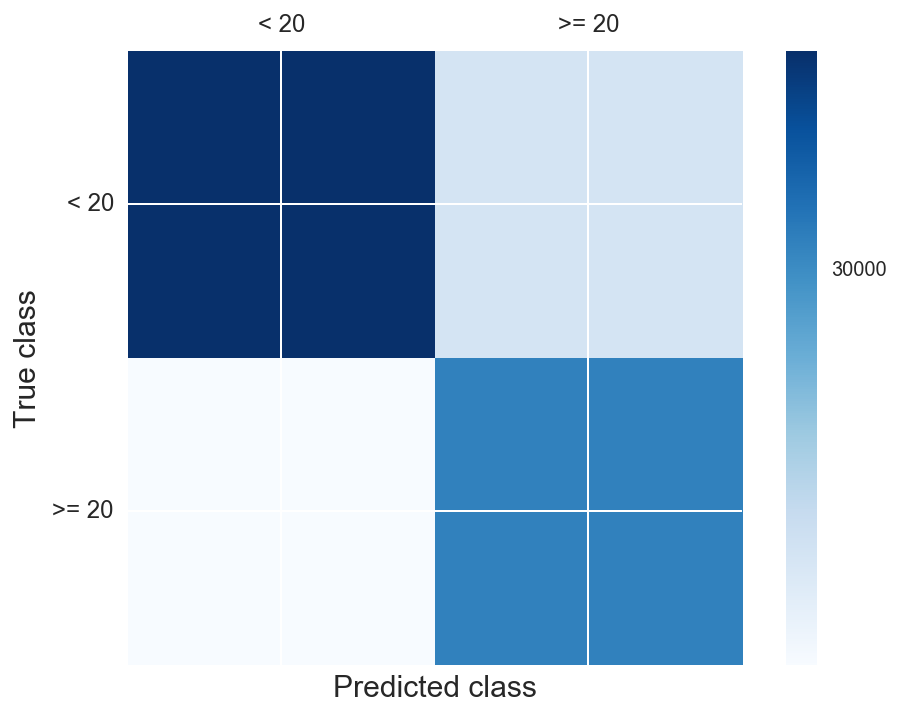

In [25]:
first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, ax = plt.subplots()

colorbar = ax.matshow(cm, cmap=cmap.Blues)
fig.colorbar(colorbar, ticks=[30000, 90000, 150000, 210000, 270000, 330000, 390000])

ax.set_xlabel('Predicted class', fontsize=15)
ax.set_ylabel('True class', fontsize=15)

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.tick_params(labelsize=12)

A very nice confusion matrix!

In [26]:
# A function for plotting a couple of AUC, one per class.
def plot_auc(a_scores, b_scores, auc_scores, messages):
    
    # First axis.
    
    a_scores_copy = {}
    a_scores_avg = {}
    
    max_length = 0
    
    for a in a_scores[classes[1]] + a_scores[classes[2]]:
        length = len(a)
        if length > max_length:
            max_length = length
    
    for c in classes[1:]:
        a_scores_copy[c] = []
        
        for a in a_scores[c]:
            length = len(a)
            
            if length < max_length:
                for i in range(length, max_length):
                    a = np.append(a, a[length - 1])
        
            a_scores_copy[c].append(a)
                
        a_scores_avg[c] = np.average(np.array(a_scores_copy[c]), axis=0)

    # Second axis.

    b_scores_copy = {}
    b_scores_avg = {}

    for c in classes[1:]:
        b_scores_copy[c] = []
        
        for b in b_scores[c]:
            length = len(b)
            
            if length < max_length:
                for i in range(length, max_length):
                    b = np.append(b, b[length - 1])
            
            b_scores_copy[c].append(b)
        
        b_scores_avg[c] = np.average(np.array(b_scores_copy[c]), axis=0)

    # Plotting.

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    i = 0

    for c in classes[1:]:
        a = a_scores_avg[c]
        b = b_scores_avg[c]
        auc_score = np.mean(auc_scores[c])

        if messages['title'] == 'ROC':
            ax[i].plot([0, 1], [0, 1], 'k--')
            ax[i].plot(a, b)
        else:
            ax[i].plot(b, a)

        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.0])
        
        if messages['title'] == 'ROC':
            ax[i].fill_between(a, b, alpha=0.5)
        else:
            ax[i].fill_between(b, a, alpha=0.5)
            
        ax[i].set_title(messages['title'] + ' curve (AUC = %0.2f) | Class "%s"' % (auc_score, c), fontsize=15)
        ax[i].set_xlabel(messages['x_label'], fontsize=15)
        ax[i].set_ylabel(messages['y_label'], fontsize=15)
        
        ax[i].tick_params(labelsize=12)
        
        i += 1

    fig.tight_layout()

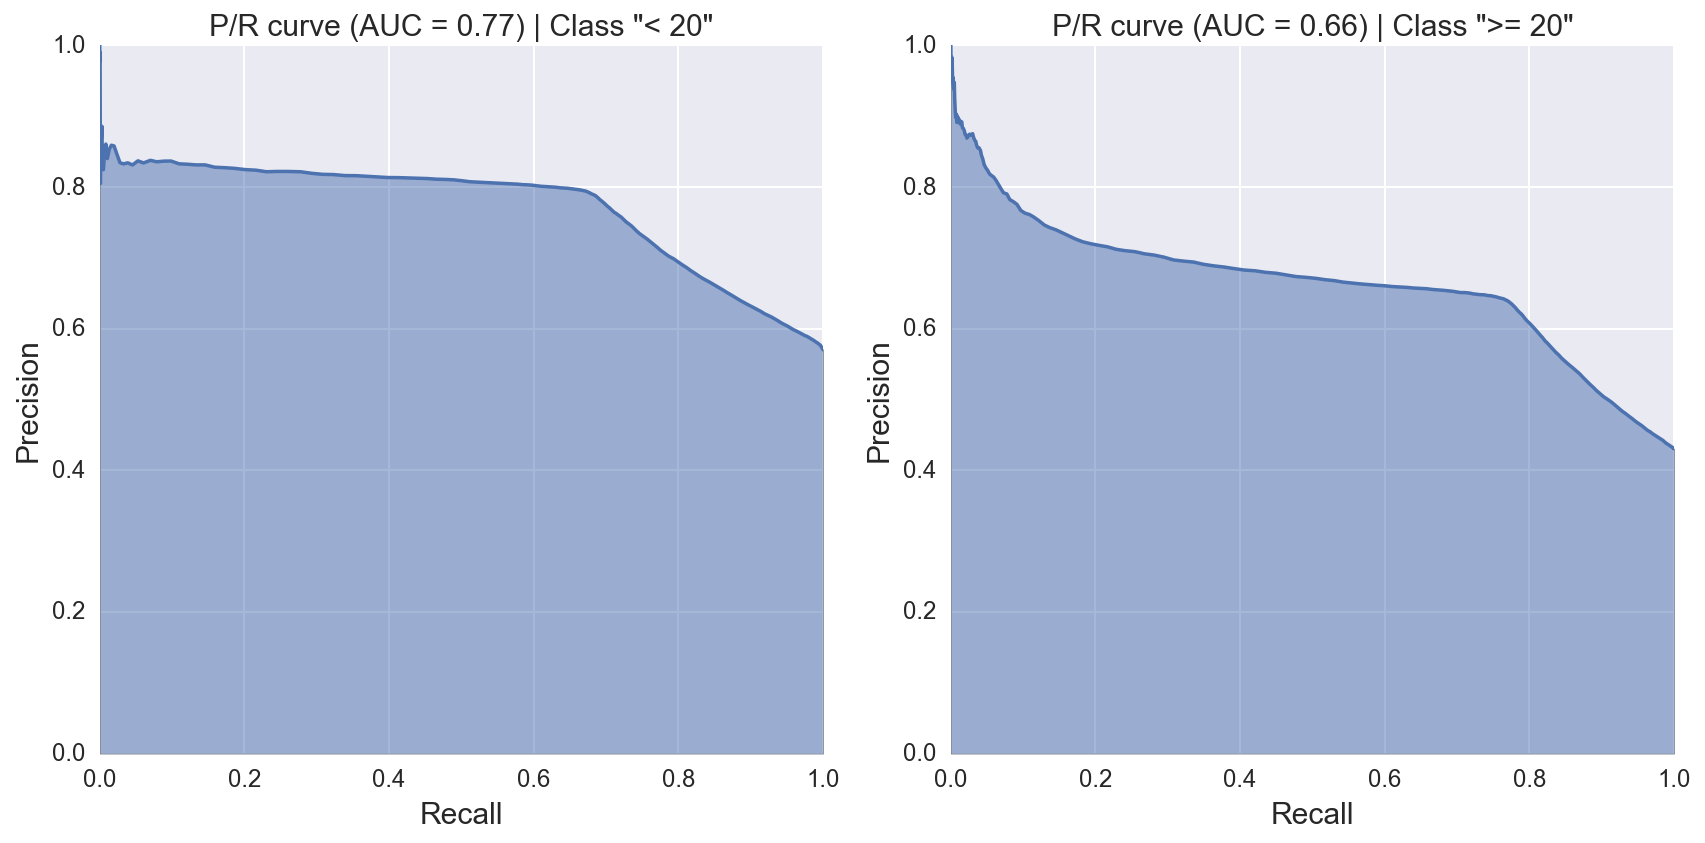

In [27]:
messages = {'title': 'P/R', 'x_label': 'Recall', 'y_label': 'Precision'}
plot_auc(precision_scores, recall_scores, pr_auc_scores, messages)

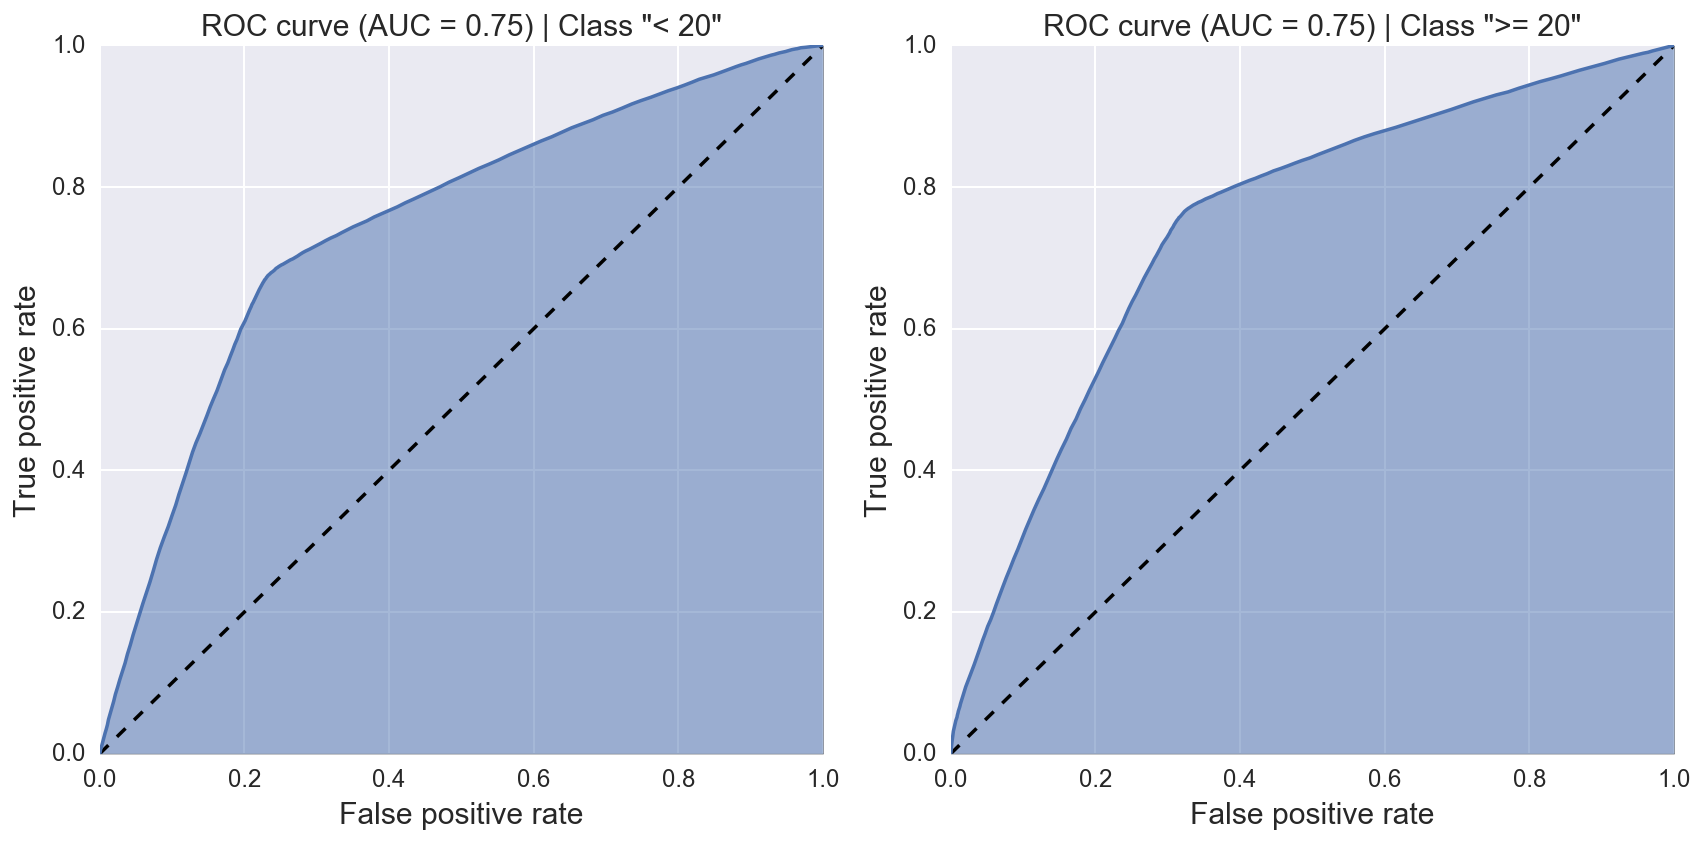

In [36]:
messages = {'title': 'ROC', 'x_label': 'False positive rate', 'y_label': 'True positive rate'}
plot_auc(fpr_scores, tpr_scores, roc_auc_scores, messages)

Both kind of curves look very good, specially the AUC ones, with an area of `0.75`.